<a href="https://colab.research.google.com/github/blondeincode/Trumps_tweet_sentiment/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment analysis and search for the most frequently used words in Donald Trump's tweets

In [1]:
!pip install -q langid
!pip install -q emoji
!pip install -q pyLDAvis

     |████████████████████████████████| 1.9MB 6.6MB/s 
     |████████████████████████████████| 133kB 5.9MB/s 
     |████████████████████████████████| 1.7MB 6.6MB/s 


In [ ]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
plt.style.use('fast')
import string
import re
import emoji
import langid
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
nltk.download('punkt') #for tokenization
nltk.download('wordnet') #for lemmatization
nltk.download('stopwords') #to remove stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Create a path to a data file
DATA_DIR = os.path.join('data')
DATA_URL = 'https://www.dropbox.com/s/qp4g1kvqwpggios/tweety_trump.zip?dl=1'
DATA_FILENAME = 'data.zip'
DATA_FILEPATH = 'os.path.join(DATA_DIR, DATA_FILENAME)'

In [ ]:
def init_directories():
  if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [ ]:
data = urllib.request.urlretrieve(DATA_URL, DATA_FILEPATH)

In [ ]:
init_directories()

with zipfile.ZipFile(DATA_FILEPATH, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR) 

In [ ]:
for path, subdirs, files in os.walk('data'):
    for name in files:
        print(os.path.join(path, name))

data/tweety_trump.csv


In [ ]:
#Open csv file with data
tweets = pd.read_csv('data/tweety_trump.csv', usecols=['text','date'], header=0, sep=',', parse_dates=['date'])
tweets

,text,date
0,Republicans and Democrats have both created ou...,2011-08-02 18:07:48
1,I was thrilled to be back in the Great city of...,2020-03-03 01:34:50
2,RT @CBS_Herridge: READ: Letter to surveillance...,2020-01-17 03:22:47
3,The Unsolicited Mail In Ballot Scam is a major...,2020-09-12 20:10:58
4,RT @MZHemingway: Very friendly telling of even...,2020-01-17 13:13:59
...,...,...
56566,RT @RandPaul: I don’t know why @JoeBiden think...,2020-10-23 03:46:25
56567,RT @EliseStefanik: President @realDonaldTrump ...,2020-10-23 03:42:05
56568,RT @TeamTrump: LIVE: Presidential Debate #Deba...,2020-10-23 01:03:58
56569,Just signed an order to support the workers of...,2020-10-22 21:04:21


In [ ]:
#Filtering records by date - we choose the time period we are interested in
tweets = tweets[(tweets['date'] >= '2017-01-20') & (tweets['date'] <= '2020-12-31' )]
tweets = tweets.reset_index(drop=True)
tweets.head()

,text,date
0,I was thrilled to be back in the Great city of...,2020-03-03 01:34:50
1,RT @CBS_Herridge: READ: Letter to surveillance...,2020-01-17 03:22:47
2,The Unsolicited Mail In Ballot Scam is a major...,2020-09-12 20:10:58
3,RT @MZHemingway: Very friendly telling of even...,2020-01-17 13:13:59
4,RT @WhiteHouse: President @realDonaldTrump ann...,2020-01-17 00:11:56


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26081 entries, 0 to 26080
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   text    26081 non-null  object        
 1   date    26081 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 407.6+ KB


In [ ]:
def findRetweeted(tweet):
    '''The function will extract people's twitter logins from the retweet'''
    return re.findall(r'(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def findMentioned(tweet):
    '''The function will extract twitter logins of people mentioned in the tweet'''
    return re.findall(r'(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def findHashtags(tweet):
    '''The function will extract the hashtags used in the tweet'''
    return re.findall(r'(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

In [ ]:
tweets['retweeted'] = tweets['text'].apply(findRetweeted)
tweets['mentioned'] = tweets['text'].apply(findMentioned)
tweets['hashtags'] = tweets['text'].apply(findHashtags)

In [ ]:
#take the rows from the hashtag column where the hashtags are located
hashtags_list_df = tweets.loc[tweets.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

#create a dataframe where each hashtag usage gets its own line
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

#the number of occurrences of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

In [ ]:
popular_hashtags = popular_hashtags.head(10)
popular_hashtags.set_index(['hashtag'], inplace = True)
popular_hashtags

,counts
hashtag,
#MAGA,436
#KAG2020,74
#COVID19,66
#USMCA,42
#USA,33
#Dorian,33
#coronavirus,28
#AmericaFirst,27
#PaycheckProtectionProgram,24


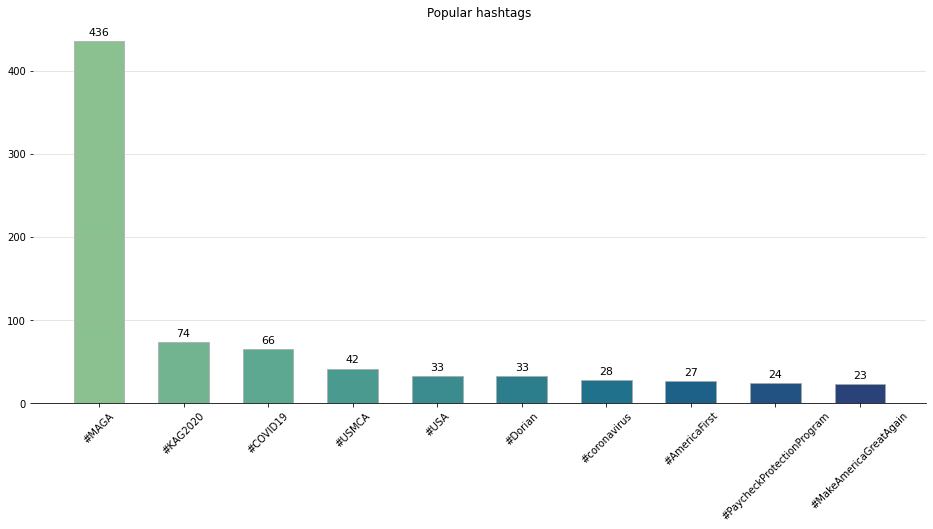

In [ ]:
#Popular hashtags
fig, ax = plt.subplots(1,1, figsize=(16, 7))
plt.title('Popular hashtags')
ax.bar(popular_hashtags.index, popular_hashtags['counts'], width=0.6,
       edgecolor='darkgray', color=sns.color_palette("crest", 10),
       linewidth=0.7)
for i in popular_hashtags.index:
  ax.annotate(f"{popular_hashtags['counts'][i]}", xy=(i, popular_hashtags['counts'][i] + 10), va = 'center', ha='center', fontsize=11, fontweight='light', color='black')
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.set_xticklabels(popular_hashtags.index, rotation=45)
ax.grid(axis='y', linestyle='-', alpha=0.4)    
plt.show()

In [ ]:
#get the rows from the retweeted column that contain the retweets
retweeted_list_df = tweets.loc[tweets.retweeted.apply(lambda retweeted_list: retweeted_list !=[]),['retweeted']]

#create a dataframe where each use of the retweet gets its own line
flattened_retweeted_df = pd.DataFrame(
    [retweeted for retweeted_list in retweeted_list_df.retweeted
    for retweeted in retweeted_list],
    columns=['retweeted'])

#the number of times each retweet has occurred
popular_retweeted = flattened_retweeted_df.groupby('retweeted').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

In [ ]:
popular_retweeted = popular_retweeted.head(10)
popular_retweeted.set_index(['retweeted'], inplace = True)
popular_retweeted

,counts
retweeted,
@realDonaldTrump,985
@WhiteHouse,665
@TeamTrump,269
@GOPChairwoman,213
@Jim_Jordan,143
@DanScavino,141
@GOP,133
@Scavino45,114
@GreggJarrett,111


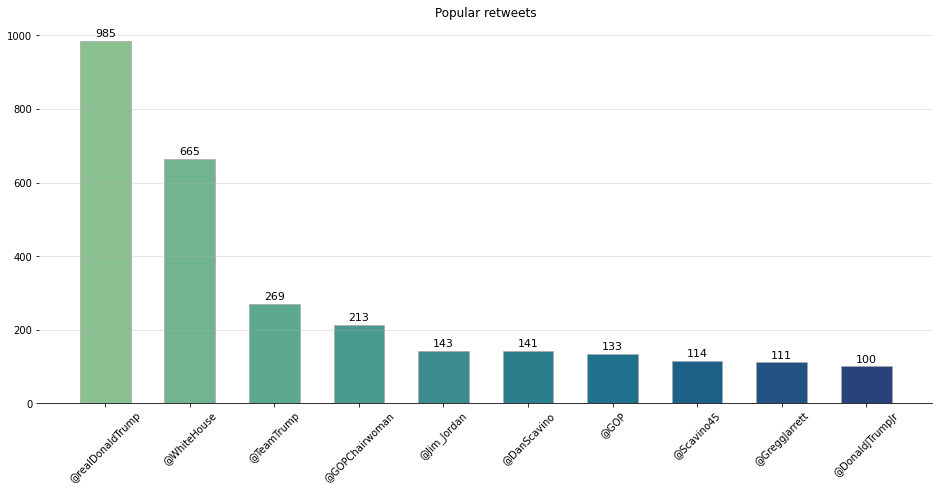

In [ ]:
#Popular retweets
fig, ax = plt.subplots(1,1, figsize=(16, 7))
plt.title('Popular retweets')
ax.bar(popular_retweeted.index, popular_retweeted['counts'], width=0.6, 
       edgecolor='darkgray', color=sns.color_palette("crest", 10),
       linewidth=0.7)
for i in popular_retweeted.index:
  ax.annotate(f"{popular_retweeted['counts'][i]}", xy=(i, popular_retweeted['counts'][i] + 20), va = 'center', ha='center', fontsize=11, fontweight='light', color='black')
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.set_xticklabels(popular_retweeted.index, rotation=45)
ax.grid(axis='y', linestyle='-', alpha=0.4)    
plt.show()

In [ ]:
#get the rows from the 'mentioned' column containing the '@' calls
mentioned_list_df = tweets.loc[tweets.mentioned.apply(lambda mentioned_list: mentioned_list !=[]),['mentioned']]

#create a dataframe where each use of the '@' call gets its own line
flattened_mentioned_df = pd.DataFrame(
    [mentioned for mentioned_list in mentioned_list_df.mentioned
    for mentioned in mentioned_list],
    columns=['mentioned'])

#number of occurrences of each '@' call
popular_mentioned = flattened_mentioned_df.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

In [ ]:
popular_mentioned = popular_mentioned.head(10)
popular_mentioned.set_index(['mentioned'], inplace = True)
popular_mentioned

,counts
mentioned,
@realDonaldTrump,1567
@FoxNews,495
@foxandfriends,303
@POTUS,189
@WhiteHouse,174
@CNN,133
@nytimes,114
@FLOTUS,105
@BreitbartNews,104


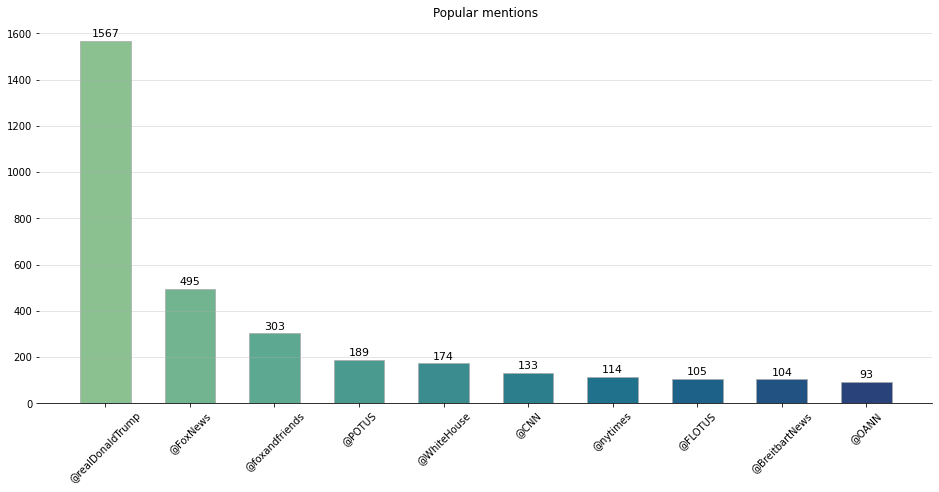

In [ ]:
#Popular mentioned
fig, ax = plt.subplots(1,1, figsize=(16, 7))
plt.title('Popular mentions')
ax.bar(popular_mentioned.index, popular_mentioned['counts'], width=0.6, 
       edgecolor='darkgray', color=sns.color_palette("crest", 10),
       linewidth=0.7)
for i in popular_mentioned.index:
  ax.annotate(f"{popular_mentioned['counts'][i]}", xy=(i, popular_mentioned['counts'][i] + 30), va = 'center', ha='center', fontsize=11, fontweight='light', color='black')
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.set_xticklabels(popular_mentioned.index, rotation=45)
ax.grid(axis='y', linestyle='-', alpha=0.4)    
plt.show()

In [ ]:
def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) #removing the '@' call
  text = re.sub(r'#', '', text) #remove '#' sign
  text = re.sub(r'RT[\s]+', '', text) #removed 'RT' retweet tag
  text = re.sub(r'https?:\/\/\S+', '', text) #removal of links
  text = re.sub(r'[.,!?:;-=\'\"$%&()*+/<>\[\\\]^_{|}~]', '', text) #remove punctuation marks
  text = re.sub(r'[0-9]+', '', text) #delete digits
  text = re.sub(r'\s+', ' ', text) #removing multiple spaces

  return text

In [ ]:
#Clear text
tweets['text'] = tweets['text'].apply(cleanTxt)

In [ ]:
#Clean up text from emoji
def emojiFreeText(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [ ]:
tweets['text'] = tweets['text'].apply(emojiFreeText)

In [ ]:
#We exclude blank tweets after cleaning
tweets = tweets[(tweets['text'] != '')]
tweets = tweets.reset_index(drop=True)
tweets

,text,date,retweeted,mentioned,hashtags
0,I was thrilled to be back in the Great city of...,2020-03-03 01:34:50,[],[],[#KAG2020]
1,Herridge READ Letter to surveillance court obt...,2020-01-17 03:22:47,[@CBS_Herridge],[],[]
2,The Unsolicited Mail In Ballot Scam is a major...,2020-09-12 20:10:58,[],[],[]
3,Very friendly telling of events here about Com...,2020-01-17 13:13:59,[@MZHemingway],[],[]
4,President announced historic steps to protect ...,2020-01-17 00:11:56,[@WhiteHouse],[@realDonaldTrump],[]
...,...,...,...,...,...
24541,I don’t know why thinks he can continue to lie...,2020-10-23 03:46:25,[@RandPaul],[@JoeBiden],[]
24542,President excels at communicating directly to ...,2020-10-23 03:42:05,[@EliseStefanik],[@realDonaldTrump],[]
24543,LIVE Presidential Debate Debates Text VOTE to,2020-10-23 01:03:58,[@TeamTrump],[],[#Debates2020]
24544,Just signed an order to support the workers of...,2020-10-22 21:04:21,[],[],[]


In [ ]:
#Identification of languages
predicted_languages = [langid.classify(tweet) for tweet in tweets['text']]

lang_df = pd.DataFrame(predicted_languages, columns=['language','value'])

#Show the top 10 languages & the number of tweets in these languages
print(lang_df['language'].value_counts().head(10))

en    23809
zh      124
fr       67
de       64
es       57
la       52
pl       29
mt       29
nl       27
it       27
Name: language, dtype: int64


In [ ]:
#We add the column 'language' to the previous table
tweets = pd.concat([tweets, lang_df['language']], axis=1)

In [ ]:
#We choose tweets written in English
tweets = tweets[(tweets['language'] == 'en')]
tweets = tweets.reset_index(drop=True)
tweets.head()

,text,date,retweeted,mentioned,hashtags,language
0,I was thrilled to be back in the Great city of...,2020-03-03 01:34:50,[],[],[#KAG2020],en
1,Herridge READ Letter to surveillance court obt...,2020-01-17 03:22:47,[@CBS_Herridge],[],[],en
2,The Unsolicited Mail In Ballot Scam is a major...,2020-09-12 20:10:58,[],[],[],en
3,Very friendly telling of events here about Com...,2020-01-17 13:13:59,[@MZHemingway],[],[],en
4,President announced historic steps to protect ...,2020-01-17 00:11:56,[@WhiteHouse],[@realDonaldTrump],[],en


In [ ]:
#tokenization, lemmatization, stopwords removal
def clean_tweet(tweet):
    tweet = tweet.lower() # lower case
    tweet_tokens = word_tokenize(tweet) #tokenization
    filtered_words = [w for w in tweet_tokens if not w in stop_words] #stopwords removal

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words] #lemmatization

    return ' '.join(filtered_words)

In [ ]:
tweets['clean_tweet'] = tweets.text.apply(clean_tweet)

In [ ]:
column_names = ['text','clean_tweet','date','retweeted','mentioned','hashtags','language']
tweets = tweets.reindex(columns=column_names)
tweets.head()

,text,clean_tweet,date,retweeted,mentioned,hashtags,language
0,I was thrilled to be back in the Great city of...,thrilled back great city charlotte north carol...,2020-03-03 01:34:50,[],[],[#KAG2020],en
1,Herridge READ Letter to surveillance court obt...,herridge read letter surveillance court obtain...,2020-01-17 03:22:47,[@CBS_Herridge],[],[],en
2,The Unsolicited Mail In Ballot Scam is a major...,unsolicited mail ballot scam major threat demo...,2020-09-12 20:10:58,[],[],[],en
3,Very friendly telling of events here about Com...,friendly telling events comeys apparent leakin...,2020-01-17 13:13:59,[@MZHemingway],[],[],en
4,President announced historic steps to protect ...,president announced historic steps protect con...,2020-01-17 00:11:56,[@WhiteHouse],[@realDonaldTrump],[],en


Analysis

In [ ]:
#subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

In [ ]:
#polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
#we are adding two new columns
tweets['subjectivity'] = tweets['clean_tweet'].apply(getSubjectivity)
tweets['polarity'] = tweets['clean_tweet'].apply(getPolarity)

In [ ]:
#Function to determine if tweet is positive, neutral or negative.
def getAnalysis(score):
  if score < 0:
    return "Negative"
  elif score == 0:
    return "Neutral"
  else:
    return "Positive"

In [ ]:
tweets['sentiment'] = tweets['polarity'].apply(getAnalysis)
tweets.head()

,text,clean_tweet,date,retweeted,mentioned,hashtags,language,subjectivity,polarity,sentiment
0,I was thrilled to be back in the Great city of...,thrilled back great city charlotte north carol...,2020-03-03 01:34:50,[],[],[#KAG2020],en,0.483333,0.450000,Positive
1,Herridge READ Letter to surveillance court obt...,herridge read letter surveillance court obtain...,2020-01-17 03:22:47,[@CBS_Herridge],[],[],en,0.100000,0.100000,Positive
2,The Unsolicited Mail In Ballot Scam is a major...,unsolicited mail ballot scam major threat demo...,2020-09-12 20:10:58,[],[],[],en,0.454762,0.029464,Positive
3,Very friendly telling of events here about Com...,friendly telling events comeys apparent leakin...,2020-01-17 13:13:59,[@MZHemingway],[],[],en,0.425000,0.212500,Positive
4,President announced historic steps to protect ...,president announced historic steps protect con...,2020-01-17 00:11:56,[@WhiteHouse],[@realDonaldTrump],[],en,0.200794,0.095238,Positive


In [ ]:
column_names = ['text','clean_tweet','date','subjectivity','polarity','sentiment','retweeted','mentioned','hashtags','language']
tweets = tweets.reindex(columns=column_names)

In [ ]:
tweets['month'] = (tweets['date']).dt.date
tweets['month'] = pd.to_datetime(tweets['month'], format='%Y-%m-%d')
tweets.head()

,text,clean_tweet,date,subjectivity,polarity,sentiment,retweeted,mentioned,hashtags,language,month
0,I was thrilled to be back in the Great city of...,thrilled back great city charlotte north carol...,2020-03-03 01:34:50,0.483333,0.450000,Positive,[],[],[#KAG2020],en,2020-03-03
1,Herridge READ Letter to surveillance court obt...,herridge read letter surveillance court obtain...,2020-01-17 03:22:47,0.100000,0.100000,Positive,[@CBS_Herridge],[],[],en,2020-01-17
2,The Unsolicited Mail In Ballot Scam is a major...,unsolicited mail ballot scam major threat demo...,2020-09-12 20:10:58,0.454762,0.029464,Positive,[],[],[],en,2020-09-12
3,Very friendly telling of events here about Com...,friendly telling events comeys apparent leakin...,2020-01-17 13:13:59,0.425000,0.212500,Positive,[@MZHemingway],[],[],en,2020-01-17
4,President announced historic steps to protect ...,president announced historic steps protect con...,2020-01-17 00:11:56,0.200794,0.095238,Positive,[@WhiteHouse],[@realDonaldTrump],[],en,2020-01-17


In [ ]:
print('Number of positive tweets:',len(tweets[(tweets['sentiment'] == 'Positive')]),'\n')
print('Number of neutral tweets:',len(tweets[(tweets['sentiment'] == 'Neutral')]),'\n')
print('Number of negative tweets:',len(tweets[(tweets['sentiment'] == 'Negative')]),'\n')
print('The sum of all tweets:',len(tweets[(tweets['sentiment'] == 'Positive')])+len(tweets[(tweets['sentiment'] == 'Neutral')])+len(tweets[(tweets['sentiment'] == 'Negative')]))

Number of positive tweets: 11996 

Number of neutral tweets: 6674 

Number of negative tweets: 5139 

The sum of all tweets: 23809


In [ ]:
viz = tweets.groupby(tweets['month'].dt.year)[['text']].count()
viz

,text
month,
2017,2386
2018,3432
2019,7286
2020,10705


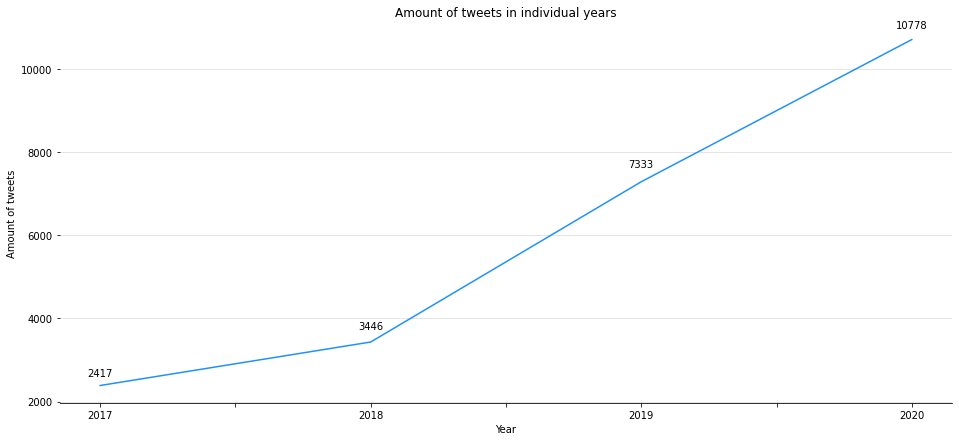

In [ ]:
#Visualization of the number of tweets in individual years
fig, ax = plt.subplots(figsize=(16,7))
viz.plot(ax=ax, color=['dodgerblue'], legend=False)
plt.title('Amount of tweets in individual years')
plt.style.use('fast')
ax.set_xlabel('Year')
ax.set_ylabel('Amount of tweets') 
ax.annotate('2417', (2017, 2417+200), ha='center')
ax.annotate('3446', (2018, 3446+300), ha='center')
ax.annotate('7333', (2019, 7333+300), ha='center')
ax.annotate('10778', (2020, 10778+200), ha='center')
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.set_xticklabels(['','2017','','2018','','2019','','2020'])
ax.grid(axis='y', linestyle='-', alpha=0.4)    
plt.show()

Tweets split by years:

In [ ]:
year2017 = tweets[(tweets['date'] >= '2017-01-20') & (tweets['date'] <= '2017-12-31' )]
year2017 = year2017.reset_index(drop=True)

In [ ]:
year2018 = tweets[(tweets['date'] >= '2018-01-01') & (tweets['date'] <= '2018-12-31' )]
year2018 = year2018.reset_index(drop=True)

In [ ]:
year2019 = tweets[(tweets['date'] >= '2019-01-01') & (tweets['date'] <= '2019-12-31' )]
year2019 = year2019.reset_index(drop=True)

In [ ]:
year2020 = tweets[(tweets['date'] >= '2020-01-01') & (tweets['date'] <= '2020-12-31' )]
year2020 = year2020.reset_index(drop=True)

**Year 2017**



In [ ]:
group2017 = year2017.groupby([year2017['month'].dt.month, 'sentiment'])[['sentiment']].count()
group2017.columns = ['count']
group2017

count
month sentiment       
1     Negative      18
      Neutral       22
      Positive      32
2     Negative      45
      Neutral       28
      Positive      80
3     Negative      27
      Neutral       41
      Positive      73
4     Negative      31
      Neutral       36
      Positive      80
5     Negative      34
      Neutral       46
      Positive      70
6     Negative      41
      Neutral       61
      Positive     103
7     Negative      48
      Neutral       60
      Positive     127
8     Negative      53
      Neutral       64
      Positive     143
9     Negative      43
      Neutral       76
      Positive     173
10    Negative      58
      Neutral       75
      Positive     150
11    Negative      56
      Neutral       48
      Positive     148
12    Negative      43
      Neutral       36
      Positive     108

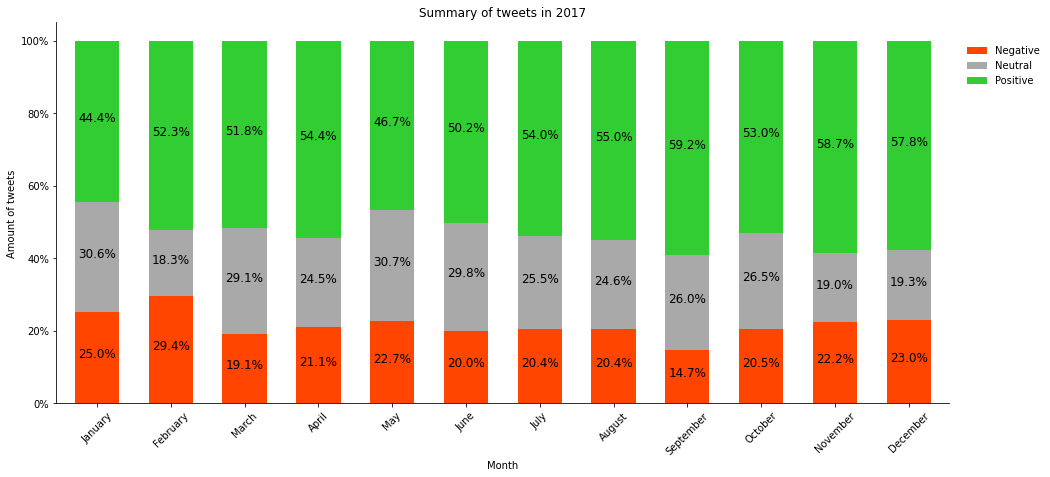

In [ ]:
#Stacked column chart
fig, ax = plt.subplots(figsize=(16,7))
group2017.groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, color=['orangered','darkgray','limegreen'], width=0.6, ax=ax)
plt.title('Summary of tweets in 2017')
ax.set_xlabel('Month')
ax.set_ylabel('Amount of tweets')
plt.xticks(rotation=45)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
#Add this loop to add the annotations
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.3}%', (x + width/2, y + height*0.5), ha='center', fontsize=12, fontweight='light')
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']) 
plt.legend(['Negative','Neutral','Positive'], bbox_to_anchor=(1.015, 0.95), loc='upper left', borderaxespad=0., frameon=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

**Year 2018**

In [ ]:
group2018 = year2018.groupby([year2018['month'].dt.month, 'sentiment'])[['sentiment']].count()
group2018.columns = ['count']
group2018

count
month sentiment       
1     Negative      54
      Neutral       16
      Positive     133
2     Negative      40
      Neutral       27
      Positive     104
3     Negative      30
      Neutral       33
      Positive     106
4     Negative      67
      Neutral       28
      Positive     156
5     Negative      68
      Neutral       35
      Positive     153
6     Negative      91
      Neutral       69
      Positive     216
7     Negative      73
      Neutral       69
      Positive     188
8     Negative     101
      Neutral       51
      Positive     205
9     Negative      62
      Neutral       83
      Positive     210
10    Negative      71
      Neutral       75
      Positive     197
11    Negative      61
      Neutral       57
      Positive     214
12    Negative      63
      Neutral       39
      Positive     176

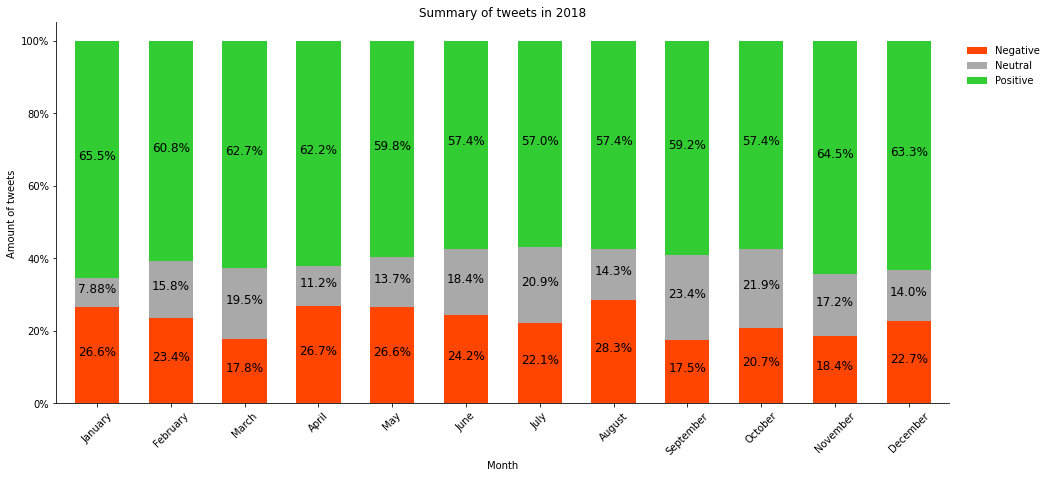

In [ ]:
#Stacked column chart
fig, ax = plt.subplots(figsize=(16,7))
group2018.groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, color=['orangered','darkgray','limegreen'], width=0.6, ax=ax)
plt.title('Summary of tweets in 2018')
ax.set_xlabel('Month')
ax.set_ylabel('Amount of tweets')
plt.xticks(rotation=45)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
#Add this loop to add the annotations
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.3}%', (x + width/2, y + height*0.5), ha='center', fontsize=12, fontweight='light')
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']) 
plt.legend(['Negative','Neutral','Positive'], bbox_to_anchor=(1.015, 0.95), loc='upper left', borderaxespad=0., frameon=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

**Year 2019**

In [ ]:
group2019 = year2019.groupby([year2019['month'].dt.month, 'sentiment'])[['sentiment']].count()
group2019.columns = ['count']
group2019

count
month sentiment       
1     Negative      76
      Neutral       71
      Positive     207
2     Negative      53
      Neutral       63
      Positive     116
3     Negative      94
      Neutral       86
      Positive     185
4     Negative     106
      Neutral       98
      Positive     212
5     Negative     146
      Neutral      185
      Positive     333
6     Negative      96
      Neutral       86
      Positive     267
7     Negative     136
      Neutral      136
      Positive     375
8     Negative     150
      Neutral      143
      Positive     364
9     Negative     173
      Neutral      213
      Positive     339
10    Negative     219
      Neutral      304
      Positive     412
11    Negative     179
      Neutral      279
      Positive     329
12    Negative     234
      Neutral      363
      Positive     424

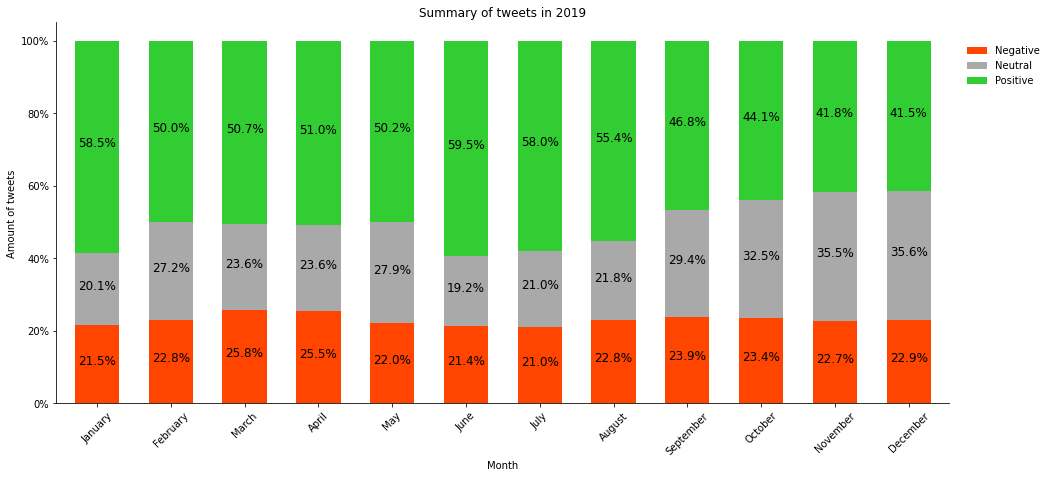

In [ ]:
#Stacked column chart
fig, ax = plt.subplots(figsize=(16,7))
group2019.groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, color=['orangered','darkgray','limegreen'], width=0.6, ax=ax)
plt.title('Summary of tweets in 2019')
ax.set_xlabel('Month')
ax.set_ylabel('Amount of tweets')
plt.xticks(rotation=45)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
#Add this loop to add the annotations
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.3}%', (x + width/2, y + height*0.5), ha='center', fontsize=12, fontweight='light')
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']) 
plt.legend(['Negative','Neutral','Positive'], bbox_to_anchor=(1.015, 0.95), loc='upper left', borderaxespad=0., frameon=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

**Year 2020**

In [ ]:
group2020 = year2020.groupby([year2020['month'].dt.month, 'sentiment'])[['sentiment']].count()
group2020.columns = ['count']
group2020

count
month sentiment       
1     Negative     182
      Neutral      292
      Positive     402
2     Negative     190
      Neutral      237
      Positive     383
3     Negative     165
      Neutral      259
      Positive     473
4     Negative     163
      Neutral      231
      Positive     364
5     Negative     213
      Neutral      330
      Positive     468
6     Negative     196
      Neutral      317
      Positive     490
7     Negative     174
      Neutral      244
      Positive     380
8     Negative     183
      Neutral      299
      Positive     425
9     Negative     218
      Neutral      404
      Positive     549
10    Negative     242
      Neutral      408
      Positive     546
11    Negative     153
      Neutral      253
      Positive     345
12    Negative     111
      Neutral      188
      Positive     228

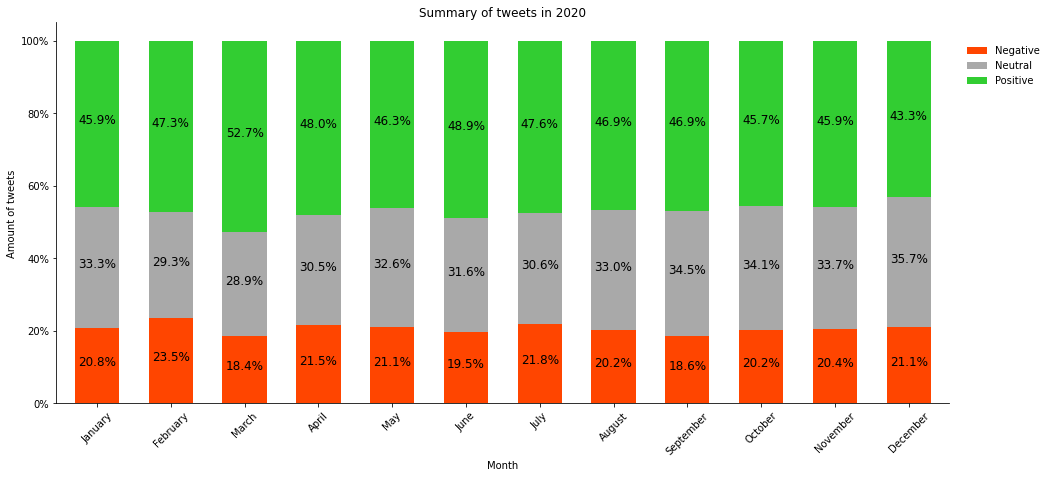

In [ ]:
#Stacked column chart
fig, ax = plt.subplots(figsize=(16,7))
group2020.groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, color=['orangered','darkgray','limegreen'], width=0.6, ax=ax)
plt.title('Summary of tweets in 2020')
ax.set_xlabel('Month')
ax.set_ylabel('Amount of tweets')
plt.xticks(rotation=45)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
#Add this loop to add the annotations
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.3}%', (x + width/2, y + height*0.5), ha='center', fontsize=12, fontweight='light')
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']) 
plt.legend(['Negative','Neutral','Positive'], bbox_to_anchor=(1.015, 0.95), loc='upper left', borderaxespad=0., frameon=False)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Thematic modeling with LDA

In [ ]:
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3, #the minimum required word occurrences
stop_words='english', #remove stop words
lowercase=True, #convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}', #number of characters > 3
max_features=5000, #maximum number of unique words
                            )
data_matrix = vectorizer.fit_transform(tweets['text'])
data_matrix

<23809x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 251052 stored elements in Compressed Sparse Row format>

In [ ]:
lda_model = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  13.530467
5       0.648955  71.707100       2        1  13.099224
4      71.019684   9.971006       3        1  10.523040
9       3.785981  33.185135       4        1   9.894517
8     -42.666500  -9.222070       5        1   9.722341
7      -3.621689 -43.526516       6        1   9.237644
3      -3.632402  -4.171708       7        1   9.060177
0     -36.584400  35.804413       8        1   9.056134
2      44.391380  50.615383       9        1   8.764089
1      40.235809 -31.591665      10        1   7.112367, topic_info=           Term         Freq        Total Category  logprob  loglift
1918      great  3703.000000  3703.000000  Default  30.0000  30.0000
4590      trump  2069.000000  2069.000000  Default  29.0000  29.0000
3411  president  2774.000000  2774.000000  Default  28.0000  28.0000
2988        new  1306.000000  1306.000000  Default  27.0000  27.0000
1618       fake  1232.000000  1232.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
4472      thing   139.486102   261.673530  Topic10  -4.8970   2.0142
1434   election   171.796548   813.205259  Topic10  -4.6886   1.0887
2991       news   186.915711  1492.331798  Topic10  -4.6043   0.5659
4157   southern   131.967841   219.230165  Topic10  -4.9524   2.1358
2664       long   131.465312   419.342288  Topic10  -4.9562   1.4834

[466 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
7         4  0.993308            able
54        6  0.997978             act
57        3  0.990926          action
67        6  0.997544            adam
80        1  0.631121  administration
...     ...       ...             ...
4982      9  0.231423           years
4982     10  0.289012           years
4985      9  0.995189       yesterday
4986      7  0.998407            york
4997      6  0.995719            zero

[541 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 5, 10, 9, 8, 4, 1, 3, 2])

In [ ]:
#Let's list the 10 most used words from each topic found by the LDA:
for i, topic in enumerate(lda_model.components_):
  print(f'Top 10 words for topic #{i}:')
  print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
  print('\n')

Top 10 words for topic #0:
['obama', 'americans', 'north', 'hunt', 'witch', 'people', 'look', 'american', 'amp', 'thank']


Top 10 words for topic #1:
['live', 'years', 'wrong', 'soon', 'including', 'today', 'white', 'good', 'president', 'house']


Top 10 words for topic #2:
['meeting', 'national', 'safety', 'federal', 'jobs', 'security', 'report', 'republican', 'president', 'trump']


Top 10 words for topic #3:
['doesn', 'times', 'washington', 'best', 'york', 'things', 'amp', 'campaign', 'economy', 'new']


Top 10 words for topic #4:
['right', 'trade', 'just', 'world', 'china', 'united', 'states', 'media', 'fake', 'news']


Top 10 words for topic #5:
['republicans', 'left', 'election', 'just', 'don', 'vote', 'country', 'did', 'want', 'democrats']


Top 10 words for topic #6:
['doing', 'thank', 'job', 'make', 'amp', 'state', 'people', 'america', 'big', 'great']


Top 10 words for topic #7:
['hard', 'clinton', 'hillary', 'dollars', 'year', 'schiff', 'time', 'collusion', 'fbi', 'dems']

